In [14]:
#  Part of the LLVM Project, under the Apache License v2.0 with LLVM Exceptions.
#  See https://llvm.org/LICENSE.txt for license information.
#  SPDX-License-Identifier: Apache-2.0 WITH LLVM-exception
#  Also available under a BSD-style license. See LICENSE.

## Setup

### Configuring Jupyter kernel.

We assume that you have followed the instructions for setting up Torch-MLIR. See [README.md](https://github.com/llvm/torch-mlir) if not.

To run this notebook, you need to configure Jupyter to access the Torch-MLIR Python modules that are built as part of your development setup. An easy way to do this is to run the following command with the same Python (and shell) that is correctly set up and able to run the Torch-MLIR end-to-end tests with RefBackend:

```shell
python -m ipykernel install --user --name=torch-mlir --env PYTHONPATH "$PYTHONPATH"
```

You should then have an option in Jupyter to select this kernel for running this notebook.

**TODO**: Make this notebook standalone and work based entirely on pip-installable packages.




### Additional dependencies for this notebook

In [15]:
!python -m pip install requests pillow

Defaulting to user installation because normal site-packages is not writeable


## Imports

### torch-mlir imports

In [16]:
import torch
import torchvision

import torch_mlir
from torch_mlir.jit_ir_importer import ClassAnnotator, ModuleBuilder
from torch_mlir.jit_ir_importer.torchscript_annotations import extract_annotations

from torch_mlir.passmanager import PassManager
from torch_mlir_e2e_test.linalg_on_tensors_backends.refbackend import RefBackendLinalgOnTensorsBackend

### General dependencies

In [17]:
import requests
from PIL import Image

### Utilities

In [18]:
def compile_and_load_on_refbackend(module):
    """Compile an MLIR Module to an executable module.

    This uses the Torch-MLIR reference backend which accepts
    linalg-on-tensors as the way to express tensor computations.
    """
    backend = RefBackendLinalgOnTensorsBackend()
    compiled = backend.compile(module)
    return backend.load(compiled)

## Basic tanh module

A simple tiny module that is easier to understand and look at than a full ResNet.

In [19]:
class TanhModule(torch.nn.Module):
    def forward(self, a):
        return torch.tanh(a)

# Compile the model with an example input.
# We lower to the linalg-on-tensors form that the reference backend supports.
compiled = torch_mlir.torchscript.compile(TanhModule(), torch.ones(3), output_type=torch_mlir.OutputType.LINALG_ON_TENSORS)
# Load it on the reference backend.
jit_module = compile_and_load_on_refbackend(compiled)
# Run it!
jit_module.forward(torch.tensor([-1.0, 1.0, 0.0]).numpy())

array([-0.7615941,  0.7615941,  0.       ], dtype=float32)

## ResNet Inference

Do some one-time preparation.

In [20]:
def _load_labels():
    classes_text = requests.get(
        "https://raw.githubusercontent.com/cathyzhyi/ml-data/main/imagenet-classes.txt",
        stream=True,
    ).text
    labels = [line.strip() for line in classes_text.splitlines()]
    return labels
IMAGENET_LABELS = _load_labels()

def _get_preprocess_transforms():
    # See preprocessing specification at: https://pytorch.org/vision/stable/models.html
    T = torchvision.transforms
    return T.Compose(
        [
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
PREPROCESS_TRANSFORMS = _get_preprocess_transforms()

Define some helper functions.

In [21]:
def fetch_image(url: str):
    # Use some "realistic" User-Agent so that we aren't mistaken for being a scraper.
    headers = {"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"}
    return Image.open(requests.get(url, headers=headers, stream=True).raw).convert("RGB")

def preprocess_image(img: Image):
    # Preprocess and add a batch dimension.
    return torch.unsqueeze(PREPROCESS_TRANSFORMS(img), 0)

### Fetch our sample image.

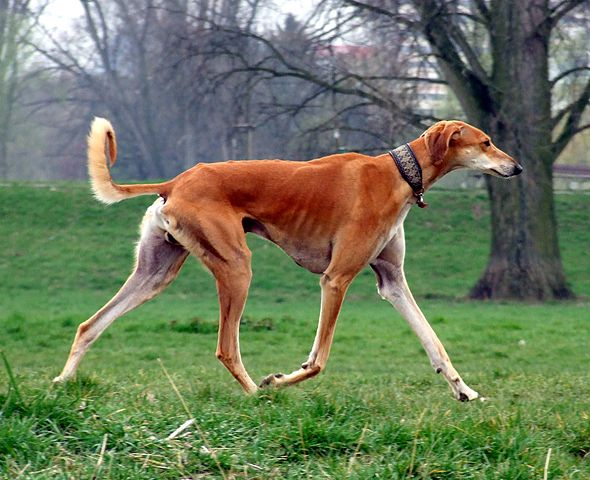

In [22]:
img = fetch_image("https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Red_Smooth_Saluki.jpg/590px-Red_Smooth_Saluki.jpg")
img_preprocessed = preprocess_image(img)

img

### Define the module and compile it

In [23]:
resnet18 = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
resnet18.eval()
compiled = torch_mlir.torchscript.compile(resnet18, torch.ones(1, 3, 224, 224), output_type="linalg-on-tensors")
jit_module = compile_and_load_on_refbackend(compiled)

KeyboardInterrupt: 

### Execute the classification!

In [ ]:
logits = torch.from_numpy(jit_module.forward(img_preprocessed.numpy()))

In [ ]:
# Torch-MLIR doesn't currently support these final postprocessing operations, so perform them in Torch.
def top3_possibilities(logits):
    _, indexes = torch.sort(logits, descending=True)
    percentage = torch.nn.functional.softmax(logits, dim=1)[0] * 100
    top3 = [(IMAGENET_LABELS[idx], percentage[idx].item()) for idx in indexes[0][:3]]
    return top3

In [ ]:
top3_possibilities(logits)

[('Saluki, gazelle hound', 74.8702163696289),
 ('Ibizan hound, Ibizan Podenco', 18.07537841796875),
 ('whippet', 6.3394775390625)]